# Sequence Modeling Mini-Project
### Jeremy Ryan

In this mini-project, I'm using n-grams to analyze and predict character-by-character behavior of text files. In this case, I'm using a list of Massachusetts town names and a list of ice cream flavors from Wikipedia.

Furthermore, I attempt to classify words as either MA town names or flavors based on likelihood of having been synthesized with this method.

In [229]:
import random
import matplotlib.pyplot as plt

In [230]:
# Load list of Massachusetts town names
source_path = "mass_names.txt"
with open(source_path) as f:
    names = [line.lower() for line in f.readlines()]

# Print first ten names alphabetically
for item in names[:10]:
    print(item.strip().capitalize())

Abington
Acushnet center
Adams
Agawam
Amesbury
Amherst center
Andover
Arlington
Athol
Attleboro


In [231]:
def ngrams_from_string(s, n):
    """ Returns a list of n-grams generated from a string input s. 
        No special provisions for special characters, like newlines.
    """
    
    ngrams = []
    
    if n > len(s):  # A length 3 word has no 4-grams
        return ngrams
    else:
        for i in range(len(s) - n + 1):
            start_idx = i
            end_idx = i + n
            ngrams.append(s[start_idx:end_idx])
    
    return ngrams


print(ngrams_from_string("Paul Ruvolo", 3))
print(ngrams_from_string("Sam Michalka", 7))
print(ngrams_from_string("Machine Learning", 17))

['Pau', 'aul', 'ul ', 'l R', ' Ru', 'Ruv', 'uvo', 'vol', 'olo']
['Sam Mic', 'am Mich', 'm Micha', ' Michal', 'Michalk', 'ichalka']
[]


In [232]:
def ngrams_from_string_list(l, n):
    """ Returns a list of all n-grams generated from a list of strings l. """
    ngrams = []
    for s in l:
        ngrams.extend(ngrams_from_string(s, n))
    return ngrams

# Print some examples from Mass towns
trigrams = ngrams_from_string_list(names, 3)
random.shuffle(trigrams)
print(trigrams[:10])

['mbr', 'ld\n', 'lex', 'hfi', 'lia', 'emb', 'rth', 'nte', 'oug', 'ndo']


In [233]:
def dict_from_ngrams(ngrams):
    """ Given a list of n-gram strings, returns a dictionary mapping
        the first n - 1 characters of any n-gram to a list of possible
        nth characters.
    """
    ngram_dict = {}
    
    for item in ngrams:
        key = item[:-1]
        value = item[-1]
        ngram_dict[key] = ngram_dict.get(key, []) + [value]
    
    return ngram_dict

print(dict_from_ngrams(trigrams[:10]))

{'mb': ['r'], 'ld': ['\n'], 'le': ['x'], 'hf': ['i'], 'li': ['a'], 'em': ['b'], 'rt': ['h'], 'nt': ['e'], 'ou': ['g'], 'nd': ['o']}


In [234]:
def generate_names(data, max_n=4, size=20):
    """ Generates a list of names with a given size based on the training data. 
        Uses n-gram synthesis, with a maximum degree of n.
    """
    
    # Create a dictionary mapping degree of ngram to a dictionary
    # generated by dict_from_ngrams of that degree
    degree_to_ngram_dict = {}
    for i in range(max_n):
        degree = i + 1
        ngrams = ngrams_from_string_list(data, degree)
        degree_to_ngram_dict[degree] = dict_from_ngrams(ngrams)
    
    names = []
    while len(names) < size:
        
        # Assemble names with largest n-gram available, up to max_n,
        # depending on current length
        name = ""
        while "\n" not in name:
            degree = min(len(name) + 1, max_n)
            key = name[-degree + 1:]
            new_chars = degree_to_ngram_dict[degree][key]
            name += random.choice(new_chars)
            
        # Reject short names
        if len(name) < 5:
            continue
            
        # Reject multiple-word names if the first word is too short
        first_word = name.split()[0]
        if len(first_word) < 4:
            continue
            
        # And, for fun, reject names that are in the training data already
        if name in data:
            continue
            
        names.append(name)
        
    return names

In [245]:
# let's generate some (fictional) town names! Some of my favorites:
# Bury
# Quinchend
# Harwich
# Ablehead
# Harbleheadington Concorne
# Slandolph

for name in generate_names(names, max_n=4, size=20):
    words = name.split()
    words = [word.capitalize().strip() for word in words]
    print(" ".join(words))

Kefield
Island
Forth Plymouth
Lyoke
Rough Center
Islancassett Islandon
Eeseconumenter
Tter
Edham
Inessex
Harwich
Nsfield Center
Orth Sesamel
Chatholbrookfield
Orester
Rshfield
Ingfield
Wake
Okfield
Thampton


In [264]:
# How does this look for ice cream flavors?
# I borrowed Wikipedia's list of ice cream flavors to train,
# and I'm getting flavors like:
# Brickle
# Ookie De Leche
# Ripple
# Frutter Tail
# Pralines and Raisin
# Fish Toffee
# Supermango

# Load names
source_path = "ice_cream.txt"
with open(source_path) as f:
    names = [line.lower() for line in f.readlines()]

# Generate artificial names
for name in generate_names(names, max_n=4, size=20):
    words = name.split()
    words = [word.capitalize().strip() for word in words]
    print(" ".join(words))

Rian
Cotch
Tanilla
Tachip
Mame
Pumon Sorbet
Chio
Urian
Astard
Orango
Mint
Acciate Chocolate
Rawberry Carame
Tter
Eapple
Iger Pecan
Plit
Chocolate Cherry Cake
Berry Candy Cake
Ipple


In [237]:
# I want to make some tools to analyze the probability of belonging to a
# given dataset. To start, I'll make it easy to iterate along a string 
# with a given window size.

def rotating_window(iterable, window_size, step_size=1):
    """ Yields each successive window of size window_size in an iterable. 
    
        Additionally, starts by iterating the first 1, 2, 3, ... step_size elements in sequence.
        
        For instance, rotating_window("abcd", 3) yields ["a", "ab", "abc", "bcd"]
    """
    start_index = -window_size + 1
    while start_index <= len(iterable) - window_size:
        actual_start_index = max(start_index, 0)
        yield iterable[actual_start_index:start_index + window_size]
        start_index += step_size

        
# This function gives the probability that a given word was generated using n-gram synthesis.
        
def calculate_probability(data, observed, max_n=4):
    """ Calculates the probability that an observed word was generated
        using n-gram synthesis from a particular set of data.
    """
    
    observed += "\n" # Data we're comparing to terminates in newlines
    
    # Assemble dictionary of ngrams
    degree_to_ngram_dict = {}
    for i in range(max_n):
        degree = i + 1
        ngrams = ngrams_from_string_list(data, degree)
        degree_to_ngram_dict[degree] = dict_from_ngrams(ngrams)
    
    # Calculate probability of each additional letter occurring.
    probability = 1.0
    for window in rotating_window(observed, max_n):
        window_size = len(window)
        prior = window[:-1]
        final = window[-1]
        ngram_dict = degree_to_ngram_dict[window_size]
        possible_finals = ngram_dict.get(prior, [])
        final_count = possible_finals.count(final)
        step_chance = (final_count + 1)/(len(possible_finals) + 1)
        probability *= step_chance
    
    return probability

In [238]:
# Now, let's see if we can effectively classify whether a given string is
# an ice cream flavor or a town in Massachusetts.

# Load names
ice_cream_path = "ice_cream.txt"
mass_path = "mass_names.txt"
names = []
ice_cream_names  = []
mass_town_names = []
labels = []
with open(ice_cream_path) as f:
    ice_cream_names = [line.lower() for line in f.readlines()]
    names.extend(ice_cream_names)
    labels.extend([1] * len(ice_cream_names))
with open(mass_path) as f:
    mass_town_names = [line.lower() for line in f.readlines()]
    names.extend(mass_town_names)
    labels.extend([0] * len(mass_town_names))

# Generate probabilities for belonging to each data set
mass_probs = [calculate_probability(mass_town_names, name) for name in names]
ice_cream_probs = [calculate_probability(ice_cream_names, name) for name in names]

In [239]:
# Sort items by likelihood of being a town name
zipped = list(zip(names, mass_probs, ice_cream_probs, labels))
sorted_by_town_likelihood = sorted(zipped, key=lambda x: x[1]/x[2])

In [240]:
# Most likely to be ice cream flavors:
print("Name, Flavor confidence")
for item in sorted_by_town_likelihood[:5]:
    print(item[0], (item[2]/(item[1]+item[2])))

Name, Flavor confidence
pralines and cream
 0.9999020211217129
french vanilla
 0.9996978031738526
mint oreo cookie
 0.9995959608373904
butterscotch
 0.9995749807107321
cookies and cream
 0.9992167061974399


In [241]:
# Most likely to be town names:
print("Name, Town confidence")
for item in sorted_by_town_likelihood[:-6:-1]:
    print(item[0], (item[1]/(item[1]+item[2])))

Name, Town confidence
barnstable town
 0.9834989163004121
east brookfield
 0.9636908649982726
holland
 0.9396013116650576
west brookfield
 0.9372226198688289
cochituate
 0.9268780797865311


In [242]:
sorted_by_confidence = sorted(zipped, key=lambda x: abs((x[1] - x[2])/(x[1] + x[2])))

# Most ambiguous words look like they tend to be town names
print("Name, Town confidence")
for item in sorted_by_confidence[:5]:
    print(item[0], (item[1]/(item[1]+item[2])))

Name, Town confidence
millis-clicquot
 0.5007288412910903
salem
 0.4943996240307042
fall river
 0.4943996240307041
boston
 0.5079155337585445
north seekonk
 0.49058363525486953


In [243]:
# Check accuracy by label type
ice_cream_accuracy = []
for item in zipped:
    if item[3] == 0: continue
    is_correct = (item[3] == (item[1]<item[2]))
    ice_cream_accuracy.append(is_correct)

accuracy = sum(ice_cream_accuracy)/len(ice_cream_accuracy)
print(f"Ice cream accuracy: {accuracy}")

town_accuracy = []
for item in zipped:
    if item[3] == 1: continue
    is_correct = (item[3] == (item[1]<item[2]))
    town_accuracy.append(is_correct)

accuracy = sum(town_accuracy)/len(town_accuracy)
print(f"Town name accuracy: {accuracy}")

Ice cream accuracy: 0.9888888888888889
Town name accuracy: 0.30638297872340425


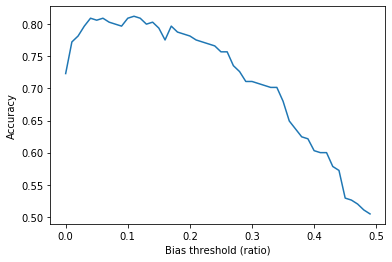

In [265]:
# It seems like it has very high confidence that things are ice cream, meaning that
# almost all 90 ice cream names are identified correctly, but town names are labeled
# worse than guessing (around 30%). I'll make some threshold to see if I can get it to
# distinguish better.

# There seems to be a peak somewhere around 0.1 (e.g., labeling as an ice cream flavor only when it's 90% sure)
# I'm not sure exactly why this is, but it gets around to 80% accuracy for a reasonably wide range of thresholds.
accuracies_list = []
thresholds = [i/100 for i in range(50)]

for threshold in thresholds:
    accuracies = []
    for item in zipped:
        ratio = item[1]/(item[2] + item[1])
        is_correct = (item[3] == (ratio < threshold))
        accuracies.append(is_correct)
    accuracies_list.append(sum(accuracies)/len(accuracies))

plt.plot(thresholds, accuracies_list)
plt.xlabel("Bias threshold (ratio)")
plt.ylabel("Accuracy")
plt.show()